###Thompson Sampling

The Thompson Sampling algorithm utilises a Bayesian probabilistic approach to modelling the reward distribution of the various arms.

A Beta distribution for each arm based on its prior parameters and its playthrough history. At each trial iteration, we will randomly sample from the posterior Beta distribution of each arm, and choose the arm which gives the max value for the next round. This allows the Thompson Sampling to balance between exploration and exploitation based on the individual posterior Beta distributions of each arm. Arms that are not explored as often as others will definitely have a wider variance, which creates opportunities for it to be picked based on stochastic sampling.

After selection of the best arm, we will play it and update the playthrough history of that arm (counts of attempts and successful reward). Note that each successful reward count will increase a_posterior while each unsuccessful reward count will increase b_posterior.

In [ ]:
import random
import numpy as np
import pandas as pd
import altair as alt
from scipy.stats import beta

In [ ]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    
    # Reward system based on Bernoulli
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

In [ ]:
def simulation_algorithm(algo, arms, num_sims, horizon):
    
    # Initialise variables for duration of accumulated simulation (num_sims * horizon_per_simulation)
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims *horizon)]
    times = [0.0 for i in range (num_sims*horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim -1) * horizon + t -1
            sim_nums[index] = sim
            times[index] = t
            
            # Selection of best arm and engaging it
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            # Engage chosen Bernoulli Arm and obtain reward info
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t ==1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward
                
            algo.update(chosen_arm, reward)
    
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [ ]:
class ThompsonSampling():
    def __init__(self, counts, values, a, b):
        self.counts = counts
        self.values = values
        
        # Beta parameters
        self.a = a
        self.b = b
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]

        # Uniform distribution of prior beta (A,B)
        self.a = [1 for arm in range(n_arms)]
        self.b = [1 for arm in range(n_arms)]
        return
    
    def select_arm(self):
        n_arms = len(self.counts)
        
        # Pair up all beta params of a and b for each arm
        beta_params = zip(self.a, self.b)
        
        # Perform random draw for all arms based on their params (a,b)
        all_draws = [beta.rvs(i[0], i[1], size = 1) for i in beta_params]
        
        # return index of arm with the highest draw
        return all_draws.index(max(all_draws))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        
        # Update a and b
        
        # a is based on total counts of rewards of arm
        self.a[chosen_arm] = self.a[chosen_arm] + reward
        
        # b is based on total counts of failed rewards on arm
        self.b[chosen_arm] = self.b[chosen_arm] + (1-reward)
        
        return

In [ ]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.4, 0.3, 0.5, 0.2, 0.1]
n_arms = len(means)
# Shuffling arms
#random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("ts_results.tsv", "w+")

# Create simulations for ThompsonSampling
algo = ThompsonSampling([], [], [], [])
algo.initialize(n_arms)
results = simulation_algorithm(algo, arms, 5000, 250)
    
# Store data
for i in range(len(results[0])):
    f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("Simulation done using Thompson Sampling, you can check result now")

Best arm is 2
Simulation done using Thompson Sampling, you can check result now


In [ ]:
df = pd.read_csv("/content/ts_results.tsv", sep = "\t", header = None, names = ["simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,simulation_num,step,chosen_arm,reward,cum_reward
0,1,1,2,1.0,1.0
1,1,2,2,0.0,1.0
2,1,3,4,0.0,1.0
3,1,4,3,0.0,1.0
4,1,5,4,0.0,1.0


In [ ]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

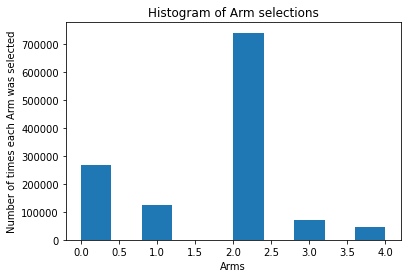

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df["chosen_arm"])
plt.title('Histogram of Arm selections')
plt.xlabel('Arms')
plt.ylabel('Number of times each Arm was selected')
plt.show()

In [ ]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["step", "chose_correct"]].groupby(["step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

In [ ]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
).properties(
    title = "TS: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [0.4,0.3, 0.5,0.2, 0.1]",
)

alt.Chart(...)

The Thompson Sampling algorithm shows a relatively quick convergence to the choice of best arm. Within 60 trials, the average rate of choosing the best arm is around 78%. This is extremely impressive compared to the other algorithms we have seen so far.

At the start, all arms are perceived equally since they all have the same priors. Thus, the rate of choosing the best arm always starts from 20%, which is a random chance of choosing the best arm out of 5 arms. As the trial progresses, the algorithm lets the playthrough history of the arms take over, and it quickly identifies the best arm with each update of the posterior Beta distribution. Note that the progression is also smooth as compared to what we observed in the UCB algorithm.

In [ ]:
df_cumreward = df.loc[:,["step", "cum_reward"]].groupby(["step"]).agg("mean").reset_index()


In [ ]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward")
).properties(
    title = "TS: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [0.4,0.3,0.5, 0.2,0.1]",
)

alt.Chart(...)

Thompson Sampling algorithm manages to identify the choice of best arm early on, it starts accumulating rewards quickly. By the end of the time horizon of 250 steps, it reaches about 105 cumulative points on average, which means it outpeforms almost all the other algorithms such as Epsilon Greedy, UCB.

In [ ]:
df_cumreward["best_cumreward"] = df["step"] * max(means)
df_cumreward["regret"] = df_cumreward["best_cumreward"]-  df_cumreward["cum_reward"]

In [ ]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("regret:Q", title = "Mean Cumulative Regret")
).properties(
    title = "TS: Mean Cumulative Regret from 5000 Simulations. 5 Arms = [0.4,0.3,0.5,0.2,0.1]",
)

alt.Chart(...)

We observe that Thompson Sampling is the best performer with a cumulative regret of 19.

#Summary
In this analysis of Thompson Sampling algorithm, started with the Baye's Rule and used a parametric assumption of Beta distributions for the priors. The overall posterior for each arm's reward function was a combination of Binomial likelihood and Beta prior, which could be represented as another Beta distribution.

Compared to the other algorithms, the Thompson Sampling algorithm provides robustness in performance regardless of arms with close reward averages and arms with big difference in reward averages.